In [115]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy import wcs
from astropy.io import fits
from congrid import congrid

import os
import sys

In [116]:
# constants
dtor = np.pi/180.0

In [117]:
def com_dist(z):
# checked against www.icosmos.co.uk    
    h=H0/100.
    c=2.99792*1.e8
    nbins=1000
    zetas = np.arange(nbins)/(nbins-1)*z
    dz=zetas[1]-zetas[0]
    hzetas=np.sqrt(Om*(1.+zetas)**(3.)+Ov)
    f=1./hzetas
    int0=np.sum(dz*f)-dz/2.*(f[0]+f[nbins-1]) # trapezium rule
    r=c*int0*1.e-5/h #comoving distance Mpc
    return r

In [118]:
def ang_size(com_size,z):
# using comoving size and comoving distance
    r=com_dist(z)
    theta=com_size/r # radians
    theta=theta/dtor
    return theta

In [119]:
def d2z(com_d):
    h=H0/100.
    c=2.99792*1.e8
    nbins=20000
    zetas = np.arange(nbins)/(nbins-1)*40.
    fint=np.asarray(zetas)
    fint = fint*0.
    for i in range(1,nbins):
        fint[i] = com_dist(zetas[i])
    test=np.abs(fint-com_d)    
    good = np.where(test == np.amin(test))
    z2 = zetas[good[0][0]]
    print(good[0][0], z2)
    return z2

In [120]:
def deltaz(z,deltay):
# redshift step corresponding to comoving distance along the line-of-sight
    d=com_dist(z)
    dd=deltay
    d2=d+dd
    d3=d-dd
    z2=d2z(d2)
    z3=d2z(d3)
    deltaz=np.abs(z2-z3)/2.
    return deltaz

In [121]:
def freq2z(v):
#v in MHz
    v0=1420.4 # 21 cm rest-frame
    z=v0/v-1.
    return z

In [122]:
def z2freq(z):
    v0=1420.4 # 21 cm rest-frame
    v=v0/(1.+z)
    return v

In [123]:
def resize_and_rebin(map1, map2, theta1, theta2):
# Select a portion of map and zoom 
    assert(theta1 >= theta2)
    nbin1 = map1.shape[0]
    nbin2 = map2.shape[0]
    nbin=int(nbin1/theta1*theta2)
    l1=(nbin1-nbin)/2
    l1=int(l1)
    l2=l1+nbin-1
    map0 = map1[l1:l2,l1:l2]
    map2 = congrid(map0,[nbin2,nbin2])
    return map2

In [124]:
fdir = "/home/vlad/software.ext/EoR/21cmFAST/Boxes/"
#outdir = "/home/vlad/data/SKAsim/DataCube/"
outdir = "./"

ffile0 = os.listdir(fdir)
# Assuming 21cmFAST-style file names (Simfast21 will have the different nameing convention)
ffile0 = filter(lambda k: ('delta_T_v3' and 'useTs') in k, ffile0)
ffile = []
for element in ffile0:
    ffile.append(element)

In [125]:
ffile.sort()

In [126]:
nz = len(ffile)
redshifts = np.zeros((nz), dtype=float)

In [127]:
for i in range(nz):
    redshifts[i] = np.float(ffile[i][12:18])
#    print(ffile[i], redshifts[i])
zstart = redshifts[0]
zend = redshifts[-1]   

In [128]:
x = np.arange(nz)
frequiencies = z2freq(redshifts)
dz = np.diff(redshifts)

In [129]:
#Cosmological parameters (to compute anglar dimension of box as function of z)
H0=70.
Om=0.28
Ov=0.72

In [130]:
#Simulation parameters
theta_fov= 1.45  # degrees  ; Fov @ 100 MHz
nbin_fov = 128  # simulated patch size, nbin_fov x nbin_fov
com_size = 300. # Mpc,  21cmfast size of cube
nbin     = 200  # 21cmfast number of pixels side of cube
pixelsize=com_size/float(nbin)
halfbin=int(nbin/2.) 

In [131]:
print("Checking the angular size of %5.1f Mpc patch." %(com_size))
for i in [0,-1]:
    fov = ang_size(com_size,redshifts[i])
    print("z=%2.2f, %3.3f deg at %3.3f MHz"%(redshifts[i], fov, frequiencies[i]))

Checking the angular size of 300.0 Mpc patch.
z=6.00, 2.036 deg at 202.914 MHz
z=29.91, 1.476 deg at 45.953 MHz


In [132]:
n_redshifts = len(redshifts)

In [133]:
#full names of 21cmfast files with the datacubes in a comoving distance
ffile_full = [fdir + x for x in ffile]

In [134]:
#an array for the deltaTb 2D maps extracted from the datacubes
map0 = np.zeros((nbin,nbin), dtype=float)        

#an array for the deltaTb observed map, nbin_fov_x_nbin_fov for a
#given theta_fov in degrees
map2 = np.zeros((nbin_fov,nbin_fov), dtype=float)

#an array for the deltaTb 3D datacube (ra, dec, freq) of EoR signal
map3d = np.zeros((nz,nbin_fov,nbin_fov), dtype=float)        

#starting y coordinate of slice along the LoS to avoid border effects
slice_y_start = 10
slice_y = slice_y_start

In [135]:
#Create FITS header for the single frequency files
# Set up an "Gnomonic" projection
# Vector properties may be set with Python lists, or Numpy arrays
# Frequency axis is incorrect (non-liear)!
w = wcs.WCS(naxis=2)
nx = nbin_fov
ny = nx
cdelt = theta_fov/nbin_fov
w.wcs.crpix = [nx/2, ny/2]
w.wcs.cdelt = np.array([-cdelt, cdelt])
w.wcs.crval = [180., 0.0]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w.wcs.cunit = ["deg", "deg"]
header = w.to_header()
hdu = fits.PrimaryHDU(header=header)
hdu.header['BUNIT'] = 'mK'

Redshift = 6.00, Delta z = 0.140, f = 202.91429
./deltaTmap_z6.00_202.914MHz.fits
SDT of the 3D cube:  1.0460733 mK
STD of the  10 slice:  1.020452 mK
Angular size of simulation is 2.0363 deg


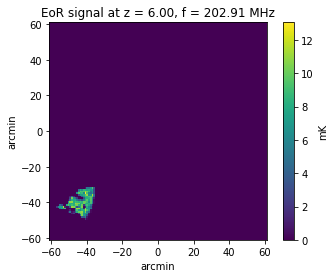

thickness= 60.06 Mpc, npx =   40 pix
******
Redshift = 6.14, Delta z = 0.140, f = 198.93557
./deltaTmap_z6.14_198.936MHz.fits
SDT of the 3D cube:  1.7334918 mK
STD of the  50 slice:  1.1217993 mK
Angular size of simulation is 2.0219 deg


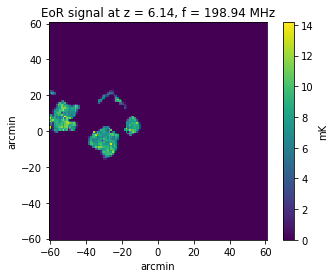

thickness= 58.33 Mpc, npx =   39 pix
******
Redshift = 6.28, Delta z = 0.150, f = 195.10989
./deltaTmap_z6.28_195.110MHz.fits
SDT of the 3D cube:  2.4189072 mK
STD of the  89 slice:  1.4734411 mK
Angular size of simulation is 2.0081 deg


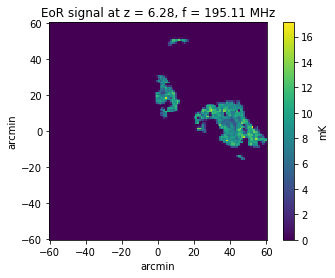

thickness= 60.67 Mpc, npx =   40 pix
******
Redshift = 6.43, Delta z = 0.150, f = 191.17093
./deltaTmap_z6.43_191.171MHz.fits
SDT of the 3D cube:  3.2328286 mK
STD of the  129 slice:  4.1290274 mK
Angular size of simulation is 1.9940 deg


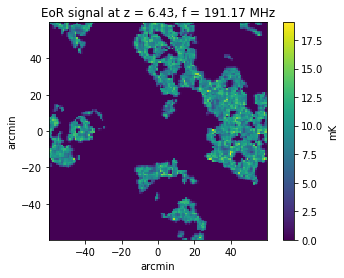

thickness= 58.87 Mpc, npx =   39 pix
******
Redshift = 6.58, Delta z = 0.150, f = 187.38786
./deltaTmap_z6.58_187.388MHz.fits
SDT of the 3D cube:  4.074941 mK
STD of the  168 slice:  4.392798 mK
Angular size of simulation is 1.9804 deg


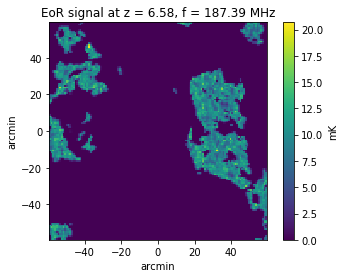

thickness= 57.16 Mpc, npx =   38 pix
beginning new cube !! 6.58
******
Redshift = 6.73, Delta z = 0.150, f = 183.75162
./deltaTmap_z6.73_183.752MHz.fits
SDT of the 3D cube:  4.897387 mK
STD of the  10 slice:  5.2658286 mK
Angular size of simulation is 1.9675 deg


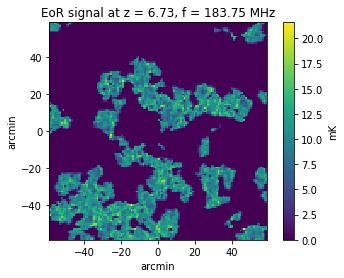

thickness= 55.53 Mpc, npx =   37 pix
******
Redshift = 6.88, Delta z = 0.160, f = 180.25381
./deltaTmap_z6.88_180.254MHz.fits
SDT of the 3D cube:  5.5840354 mK
STD of the  47 slice:  5.0236926 mK
Angular size of simulation is 1.9551 deg


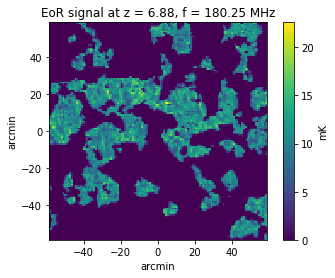

thickness= 57.52 Mpc, npx =   38 pix
******
Redshift = 7.04, Delta z = 0.160, f = 176.66667
./deltaTmap_z7.04_176.667MHz.fits
SDT of the 3D cube:  6.1525283 mK
STD of the  85 slice:  5.8960176 mK
Angular size of simulation is 1.9423 deg


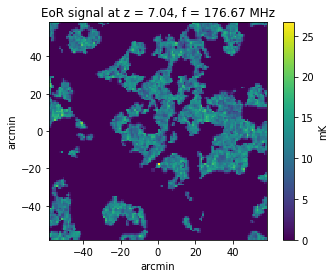

thickness= 55.84 Mpc, npx =   37 pix
******
Redshift = 7.20, Delta z = 0.170, f = 173.21951
./deltaTmap_z7.20_173.220MHz.fits
SDT of the 3D cube:  6.5830173 mK
STD of the  122 slice:  6.682757 mK
Angular size of simulation is 1.9302 deg


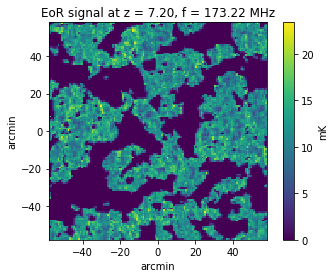

thickness= 57.57 Mpc, npx =   38 pix
******
Redshift = 7.37, Delta z = 0.160, f = 169.70131
./deltaTmap_z7.37_169.701MHz.fits
SDT of the 3D cube:  6.873378 mK
STD of the  160 slice:  6.8250194 mK
Angular size of simulation is 1.9178 deg


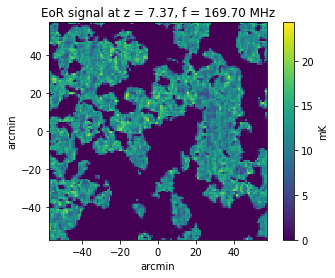

thickness= 52.61 Mpc, npx =   35 pix
beginning new cube !! 7.37
******
Redshift = 7.53, Delta z = 0.170, f = 166.51817
./deltaTmap_z7.53_166.518MHz.fits
SDT of the 3D cube:  7.030113 mK
STD of the  10 slice:  7.0053215 mK
Angular size of simulation is 1.9066 deg


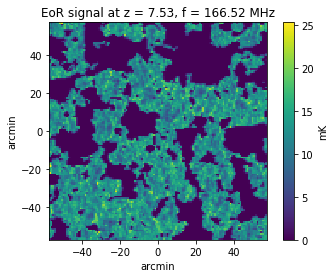

thickness= 54.31 Mpc, npx =   36 pix
******
Redshift = 7.70, Delta z = 0.180, f = 163.26437
./deltaTmap_z7.70_163.264MHz.fits
SDT of the 3D cube:  7.060904 mK
STD of the  46 slice:  7.144881 mK
Angular size of simulation is 1.8952 deg


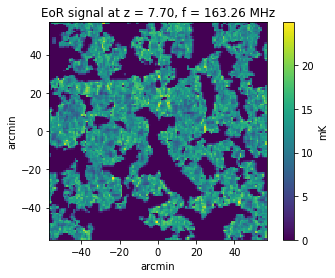

thickness= 55.80 Mpc, npx =   37 pix
******
Redshift = 7.88, Delta z = 0.180, f = 159.95495
./deltaTmap_z7.88_159.955MHz.fits
SDT of the 3D cube:  6.966505 mK
STD of the  83 slice:  7.1309996 mK
Angular size of simulation is 1.8836 deg


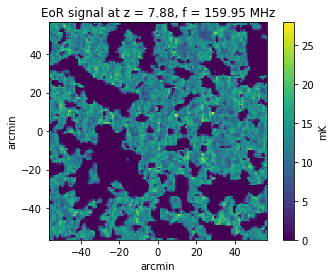

thickness= 54.14 Mpc, npx =   36 pix
******
Redshift = 8.06, Delta z = 0.180, f = 156.77704
./deltaTmap_z8.06_156.777MHz.fits
SDT of the 3D cube:  6.7475967 mK
STD of the  119 slice:  6.410666 mK
Angular size of simulation is 1.8725 deg


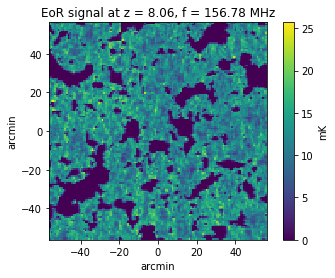

thickness= 52.55 Mpc, npx =   35 pix
******
Redshift = 8.24, Delta z = 0.180, f = 153.72294
./deltaTmap_z8.24_153.723MHz.fits
SDT of the 3D cube:  6.4094687 mK
STD of the  154 slice:  6.1736603 mK
Angular size of simulation is 1.8618 deg


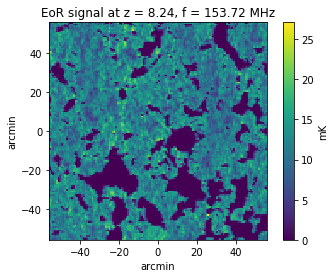

thickness= 51.04 Mpc, npx =   34 pix
******
Redshift = 8.42, Delta z = 0.190, f = 150.78556
./deltaTmap_z8.42_150.786MHz.fits
SDT of the 3D cube:  5.9487104 mK
STD of the  188 slice:  5.807197 mK
Angular size of simulation is 1.8516 deg


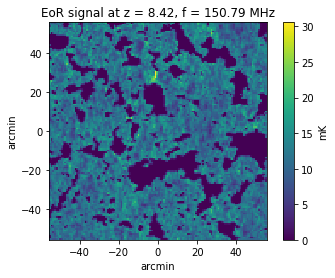

thickness= 52.32 Mpc, npx =   35 pix
beginning new cube !! 8.42
******
Redshift = 8.61, Delta z = 0.190, f = 147.80437
./deltaTmap_z8.61_147.804MHz.fits
SDT of the 3D cube:  5.373196 mK
STD of the  10 slice:  5.214405 mK
Angular size of simulation is 1.8412 deg


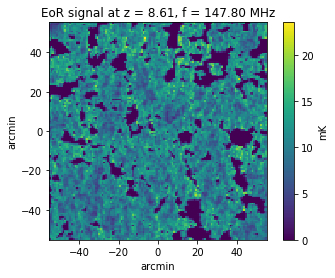

thickness= 50.80 Mpc, npx =   34 pix
******
Redshift = 8.80, Delta z = 0.200, f = 144.93878
./deltaTmap_z8.80_144.939MHz.fits
SDT of the 3D cube:  4.703803 mK
STD of the  44 slice:  5.149823 mK
Angular size of simulation is 1.8312 deg


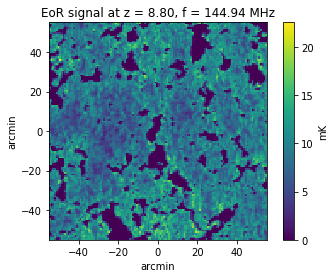

thickness= 51.90 Mpc, npx =   35 pix
******
Redshift = 9.00, Delta z = 0.200, f = 142.04000
./deltaTmap_z9.00_142.040MHz.fits
SDT of the 3D cube:  3.9932365 mK
STD of the  79 slice:  4.201406 mK
Angular size of simulation is 1.8212 deg


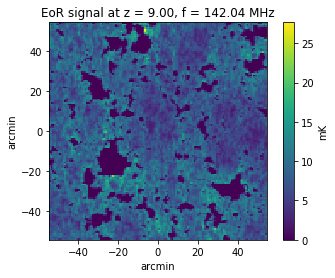

thickness= 50.37 Mpc, npx =   34 pix
******
Redshift = 9.20, Delta z = 0.200, f = 139.25490
./deltaTmap_z9.20_139.255MHz.fits
SDT of the 3D cube:  3.3911507 mK
STD of the  113 slice:  3.1176212 mK
Angular size of simulation is 1.8115 deg


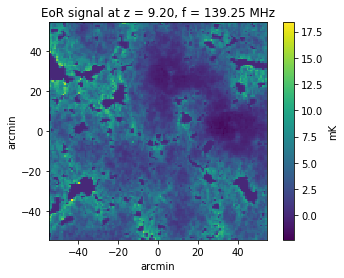

thickness= 48.91 Mpc, npx =   33 pix
******
Redshift = 9.40, Delta z = 0.210, f = 136.57692
./deltaTmap_z9.40_136.577MHz.fits
SDT of the 3D cube:  3.209567 mK
STD of the  146 slice:  3.226692 mK
Angular size of simulation is 1.8022 deg


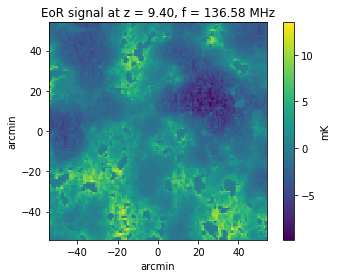

thickness= 49.87 Mpc, npx =   33 pix
******
Redshift = 9.61, Delta z = 0.210, f = 133.87370
./deltaTmap_z9.61_133.874MHz.fits
SDT of the 3D cube:  3.7850716 mK
STD of the  179 slice:  3.650257 mK
Angular size of simulation is 1.7928 deg


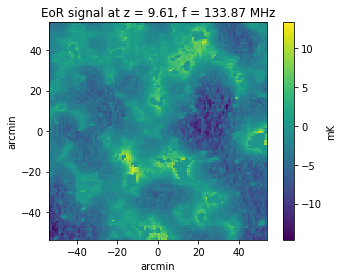

thickness= 48.41 Mpc, npx =   32 pix
beginning new cube !! 9.61
******
Redshift = 9.82, Delta z = 0.220, f = 131.27542
./deltaTmap_z9.82_131.275MHz.fits
SDT of the 3D cube:  5.026126 mK
STD of the  10 slice:  4.6366014 mK
Angular size of simulation is 1.7838 deg


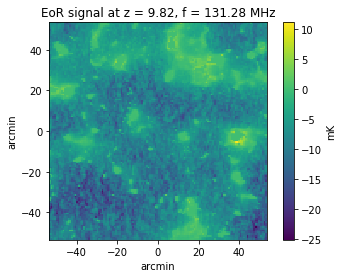

thickness= 49.23 Mpc, npx =   33 pix
******
Redshift = 10.04, Delta z = 0.220, f = 128.65942
./deltaTmap_z10.04_128.659MHz.fits
SDT of the 3D cube:  6.8078856 mK
STD of the  43 slice:  6.5932317 mK
Angular size of simulation is 1.7748 deg


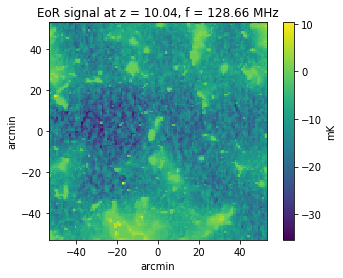

thickness= 47.78 Mpc, npx =   32 pix
******
Redshift = 10.26, Delta z = 0.230, f = 126.14565
./deltaTmap_z10.26_126.146MHz.fits
SDT of the 3D cube:  8.902717 mK
STD of the  75 slice:  7.683935 mK
Angular size of simulation is 1.7660 deg


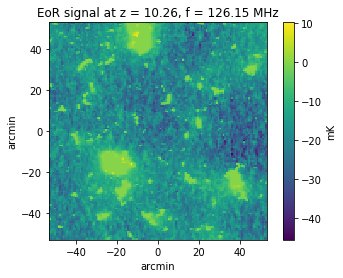

thickness= 48.48 Mpc, npx =   32 pix
******
Redshift = 10.49, Delta z = 0.220, f = 123.62054
./deltaTmap_z10.49_123.621MHz.fits
SDT of the 3D cube:  11.165433 mK
STD of the  107 slice:  11.25007 mK
Angular size of simulation is 1.7573 deg


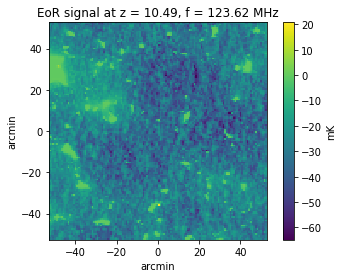

thickness= 45.04 Mpc, npx =   30 pix
******
Redshift = 10.71, Delta z = 0.240, f = 121.29804
./deltaTmap_z10.71_121.298MHz.fits
SDT of the 3D cube:  13.438103 mK
STD of the  137 slice:  14.025145 mK
Angular size of simulation is 1.7492 deg


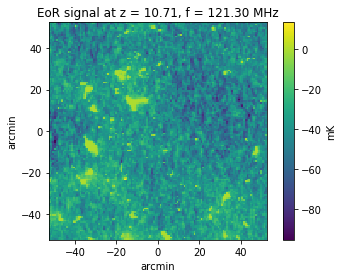

thickness= 47.71 Mpc, npx =   32 pix
******
Redshift = 10.95, Delta z = 0.240, f = 118.86192
./deltaTmap_z10.95_118.862MHz.fits
SDT of the 3D cube:  15.643839 mK
STD of the  169 slice:  15.666517 mK
Angular size of simulation is 1.7408 deg


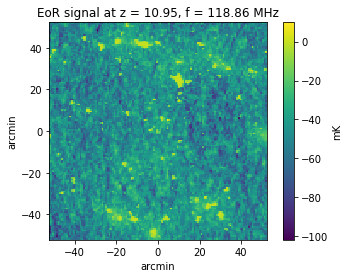

thickness= 46.29 Mpc, npx =   31 pix
beginning new cube !! 10.95
******
Redshift = 11.19, Delta z = 0.240, f = 116.52174
./deltaTmap_z11.19_116.522MHz.fits
SDT of the 3D cube:  17.60447 mK
STD of the  10 slice:  17.136824 mK
Angular size of simulation is 1.7327 deg


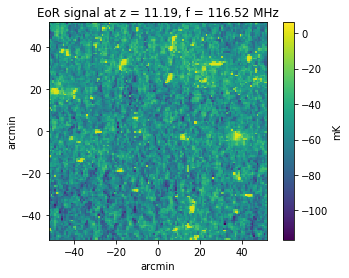

thickness= 44.95 Mpc, npx =   30 pix
******
Redshift = 11.43, Delta z = 0.250, f = 114.27192
./deltaTmap_z11.43_114.272MHz.fits
SDT of the 3D cube:  19.226604 mK
STD of the  40 slice:  19.212128 mK
Angular size of simulation is 1.7248 deg


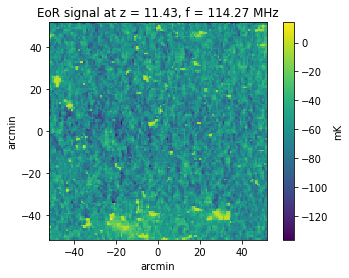

thickness= 45.46 Mpc, npx =   30 pix
******
Redshift = 11.68, Delta z = 0.250, f = 112.01893
./deltaTmap_z11.68_112.019MHz.fits
SDT of the 3D cube:  20.407299 mK
STD of the  70 slice:  19.870583 mK
Angular size of simulation is 1.7170 deg


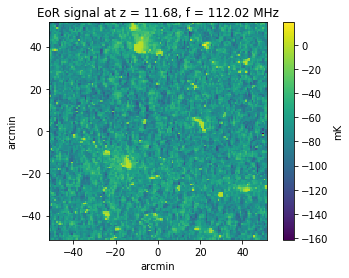

thickness= 44.13 Mpc, npx =   29 pix
******
Redshift = 11.93, Delta z = 0.260, f = 109.85305
./deltaTmap_z11.93_109.853MHz.fits
SDT of the 3D cube:  21.11412 mK
STD of the  99 slice:  20.863712 mK
Angular size of simulation is 1.7095 deg


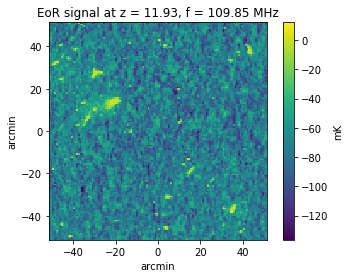

thickness= 44.56 Mpc, npx =   30 pix
******
Redshift = 12.19, Delta z = 0.270, f = 107.68764
./deltaTmap_z12.19_107.688MHz.fits
SDT of the 3D cube:  21.360607 mK
STD of the  129 slice:  21.483845 mK
Angular size of simulation is 1.7019 deg


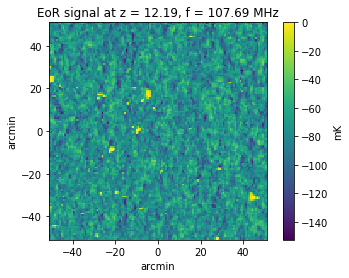

thickness= 44.91 Mpc, npx =   30 pix
******
Redshift = 12.46, Delta z = 0.270, f = 105.52749
./deltaTmap_z12.46_105.527MHz.fits
SDT of the 3D cube:  21.138874 mK
STD of the  159 slice:  21.337292 mK
Angular size of simulation is 1.6944 deg


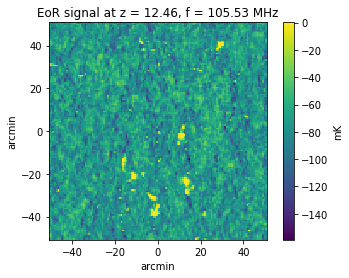

thickness= 43.58 Mpc, npx =   29 pix
******
Redshift = 12.73, Delta z = 0.270, f = 103.45229
./deltaTmap_z12.73_103.452MHz.fits
SDT of the 3D cube:  20.636312 mK
STD of the  188 slice:  20.17232 mK
Angular size of simulation is 1.6872 deg


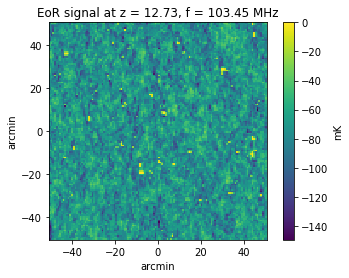

thickness= 42.31 Mpc, npx =   28 pix
beginning new cube !! 12.73
******
Redshift = 13.00, Delta z = 0.280, f = 101.45714
./deltaTmap_z13.00_101.457MHz.fits
SDT of the 3D cube:  19.815994 mK
STD of the  10 slice:  19.746634 mK
Angular size of simulation is 1.6802 deg


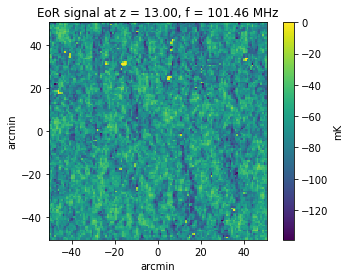

thickness= 42.61 Mpc, npx =   28 pix
******
Redshift = 13.28, Delta z = 0.290, f = 99.46779
./deltaTmap_z13.28_99.468MHz.fits
SDT of the 3D cube:  18.761171 mK
STD of the  38 slice:  19.157711 mK
Angular size of simulation is 1.6732 deg


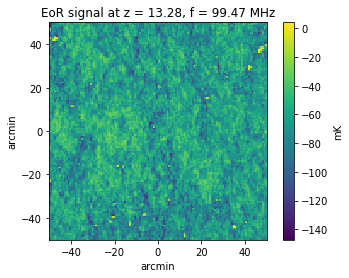

thickness= 42.83 Mpc, npx =   29 pix
******
Redshift = 13.57, Delta z = 0.290, f = 97.48799
./deltaTmap_z13.57_97.488MHz.fits
SDT of the 3D cube:  17.49627 mK
STD of the  67 slice:  17.494267 mK
Angular size of simulation is 1.6663 deg


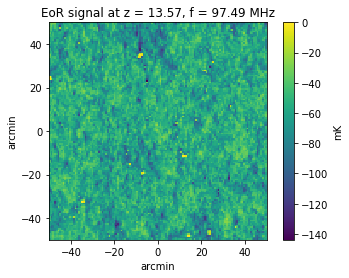

thickness= 41.57 Mpc, npx =   28 pix
******
Redshift = 13.86, Delta z = 0.290, f = 95.58546
./deltaTmap_z13.86_95.585MHz.fits
SDT of the 3D cube:  15.817851 mK
STD of the  95 slice:  16.472452 mK
Angular size of simulation is 1.6596 deg


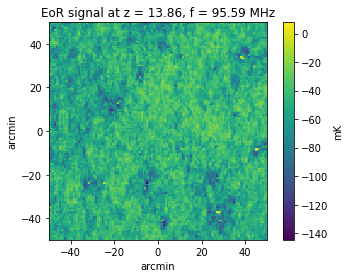

thickness= 40.37 Mpc, npx =   27 pix
******
Redshift = 14.15, Delta z = 0.310, f = 93.75578
./deltaTmap_z14.15_93.756MHz.fits
SDT of the 3D cube:  14.322097 mK
STD of the  122 slice:  13.537498 mK
Angular size of simulation is 1.6531 deg


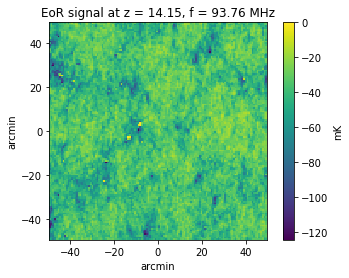

thickness= 41.89 Mpc, npx =   28 pix
******
Redshift = 14.46, Delta z = 0.310, f = 91.87581
./deltaTmap_z14.46_91.876MHz.fits
SDT of the 3D cube:  12.81196 mK
STD of the  150 slice:  12.286445 mK
Angular size of simulation is 1.6465 deg


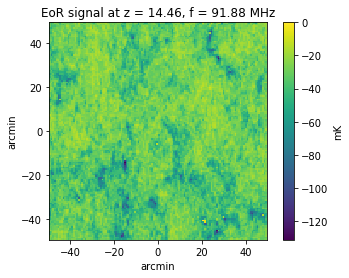

thickness= 40.65 Mpc, npx =   27 pix
******
Redshift = 14.77, Delta z = 0.310, f = 90.06975
./deltaTmap_z14.77_90.070MHz.fits
SDT of the 3D cube:  11.320634 mK
STD of the  177 slice:  10.606139 mK
Angular size of simulation is 1.6401 deg


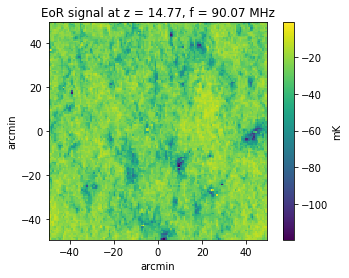

thickness= 39.47 Mpc, npx =   26 pix
beginning new cube !! 14.77
******
Redshift = 15.08, Delta z = 0.320, f = 88.33333
./deltaTmap_z15.08_88.333MHz.fits
SDT of the 3D cube:  9.934576 mK
STD of the  10 slice:  8.6817255 mK
Angular size of simulation is 1.6340 deg


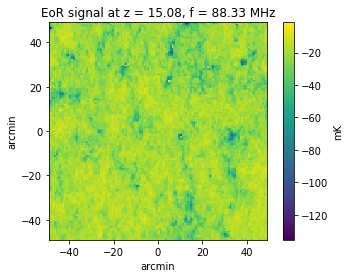

thickness= 39.57 Mpc, npx =   26 pix
******
Redshift = 15.40, Delta z = 0.330, f = 86.60976
./deltaTmap_z15.40_86.610MHz.fits
SDT of the 3D cube:  8.651917 mK
STD of the  36 slice:  8.764306 mK
Angular size of simulation is 1.6278 deg


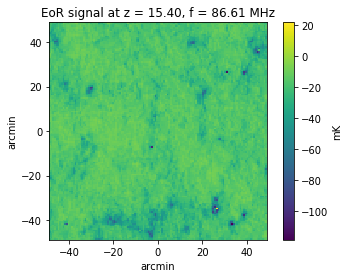

thickness= 39.61 Mpc, npx =   26 pix
******
Redshift = 15.73, Delta z = 0.340, f = 84.90137
./deltaTmap_z15.73_84.901MHz.fits
SDT of the 3D cube:  7.44658 mK
STD of the  62 slice:  6.548239 mK
Angular size of simulation is 1.6217 deg


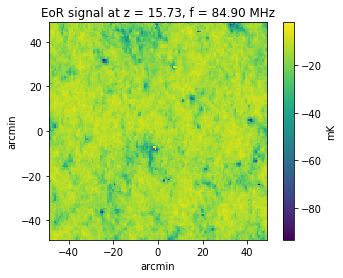

thickness= 39.60 Mpc, npx =   26 pix
******
Redshift = 16.07, Delta z = 0.340, f = 83.21031
./deltaTmap_z16.07_83.210MHz.fits
SDT of the 3D cube:  6.42455 mK
STD of the  88 slice:  6.564591 mK
Angular size of simulation is 1.6157 deg


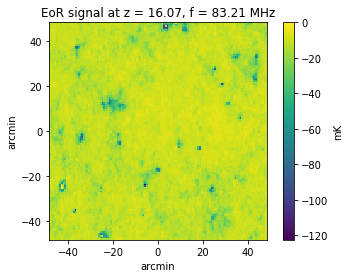

thickness= 38.44 Mpc, npx =   26 pix
******
Redshift = 16.41, Delta z = 0.350, f = 81.58530
./deltaTmap_z16.41_81.585MHz.fits
SDT of the 3D cube:  5.5352054 mK
STD of the  114 slice:  5.122932 mK
Angular size of simulation is 1.6099 deg


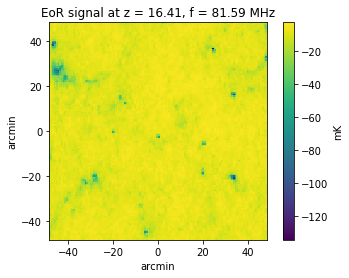

thickness= 38.41 Mpc, npx =   26 pix
******
Redshift = 16.76, Delta z = 0.350, f = 79.97748
./deltaTmap_z16.76_79.977MHz.fits
SDT of the 3D cube:  4.772932 mK
STD of the  140 slice:  4.962521 mK
Angular size of simulation is 1.6041 deg


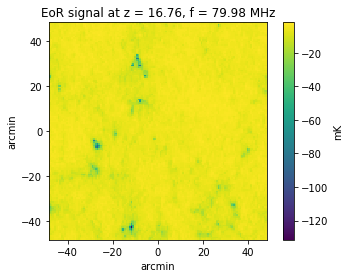

thickness= 37.29 Mpc, npx =   25 pix
******
Redshift = 17.11, Delta z = 0.360, f = 78.43181
./deltaTmap_z17.11_78.432MHz.fits
SDT of the 3D cube:  4.136055 mK
STD of the  165 slice:  2.6328459 mK
Angular size of simulation is 1.5986 deg


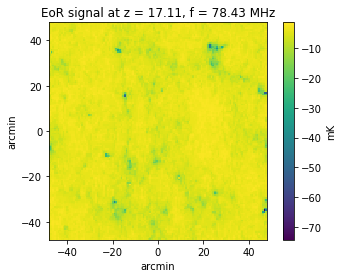

thickness= 37.25 Mpc, npx =   25 pix
******
Redshift = 17.47, Delta z = 0.370, f = 76.90309
./deltaTmap_z17.47_76.903MHz.fits
SDT of the 3D cube:  3.6179755 mK
STD of the  190 slice:  2.353436 mK
Angular size of simulation is 1.5930 deg


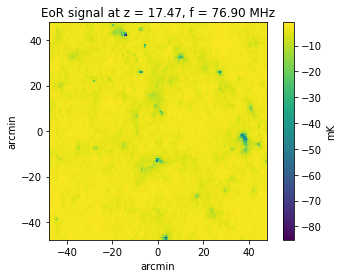

thickness= 37.16 Mpc, npx =   25 pix
beginning new cube !! 17.47
******
Redshift = 17.84, Delta z = 0.380, f = 75.39278
./deltaTmap_z17.84_75.393MHz.fits
SDT of the 3D cube:  3.1814344 mK
STD of the  10 slice:  1.989026 mK
Angular size of simulation is 1.5876 deg


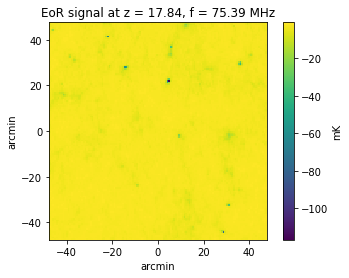

thickness= 37.05 Mpc, npx =   25 pix
******
Redshift = 18.22, Delta z = 0.380, f = 73.90219
./deltaTmap_z18.22_73.902MHz.fits
SDT of the 3D cube:  2.8336115 mK
STD of the  35 slice:  2.3039849 mK
Angular size of simulation is 1.5822 deg


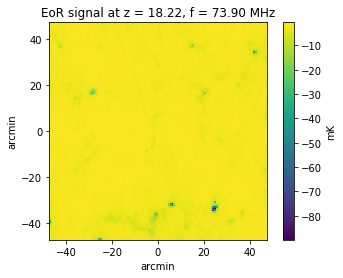

thickness= 35.96 Mpc, npx =   24 pix
******
Redshift = 18.60, Delta z = 0.400, f = 72.46939
./deltaTmap_z18.60_72.469MHz.fits
SDT of the 3D cube:  2.504852 mK
STD of the  59 slice:  2.0590363 mK
Angular size of simulation is 1.5769 deg


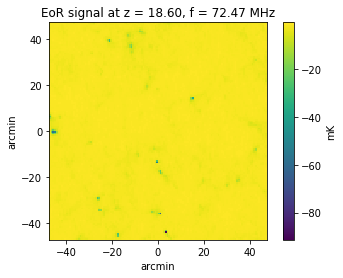

thickness= 36.74 Mpc, npx =   24 pix
******
Redshift = 19.00, Delta z = 0.400, f = 71.02000
./deltaTmap_z19.00_71.020MHz.fits
SDT of the 3D cube:  2.2036629 mK
STD of the  83 slice:  1.529739 mK
Angular size of simulation is 1.5716 deg


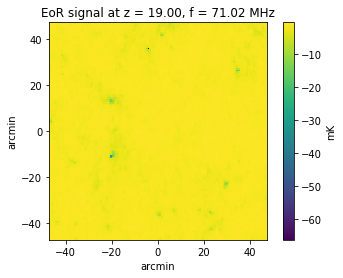

thickness= 35.66 Mpc, npx =   24 pix
******
Redshift = 19.40, Delta z = 0.400, f = 69.62745
./deltaTmap_z19.40_69.627MHz.fits
SDT of the 3D cube:  1.8999158 mK
STD of the  107 slice:  2.1050777 mK
Angular size of simulation is 1.5665 deg


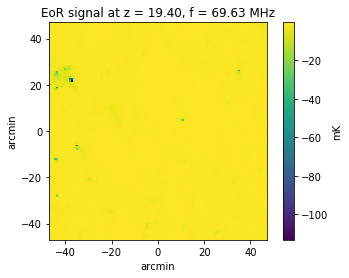

thickness= 34.63 Mpc, npx =   23 pix
******
Redshift = 19.80, Delta z = 0.420, f = 68.28846
./deltaTmap_z19.80_68.288MHz.fits
SDT of the 3D cube:  1.6814445 mK
STD of the  130 slice:  0.7306146 mK
Angular size of simulation is 1.5616 deg


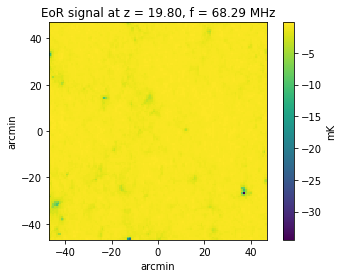

thickness= 35.30 Mpc, npx =   24 pix
******
Redshift = 20.22, Delta z = 0.420, f = 66.93685
./deltaTmap_z20.22_66.937MHz.fits
SDT of the 3D cube:  1.4043863 mK
STD of the  154 slice:  1.7217866 mK
Angular size of simulation is 1.5566 deg


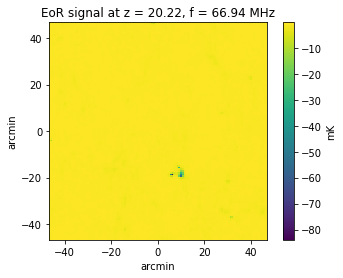

thickness= 34.27 Mpc, npx =   23 pix
******
Redshift = 20.64, Delta z = 0.440, f = 65.63771
./deltaTmap_z20.64_65.638MHz.fits
SDT of the 3D cube:  1.2369151 mK
STD of the  177 slice:  1.1257268 mK
Angular size of simulation is 1.5518 deg


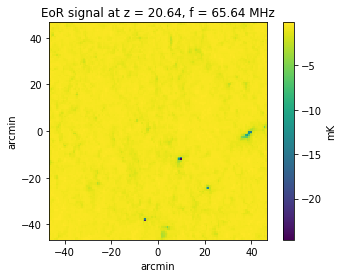

thickness= 34.84 Mpc, npx =   23 pix
beginning new cube !! 20.64
******
Redshift = 21.08, Delta z = 0.440, f = 64.32971
./deltaTmap_z21.08_64.330MHz.fits
SDT of the 3D cube:  1.0764188 mK
STD of the  10 slice:  0.63310695 mK
Angular size of simulation is 1.5469 deg


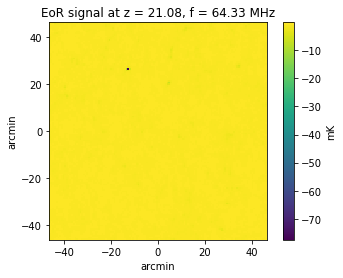

thickness= 33.82 Mpc, npx =   23 pix
******
Redshift = 21.52, Delta z = 0.450, f = 63.07282
./deltaTmap_z21.52_63.073MHz.fits
SDT of the 3D cube:  0.89231175 mK
STD of the  33 slice:  1.6481946 mK
Angular size of simulation is 1.5422 deg


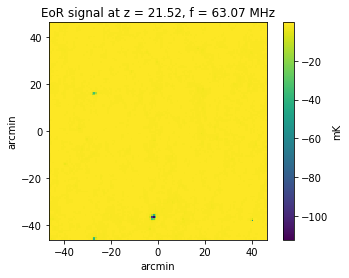

thickness= 33.58 Mpc, npx =   22 pix
******
Redshift = 21.97, Delta z = 0.460, f = 61.83718
./deltaTmap_z21.97_61.837MHz.fits
SDT of the 3D cube:  0.7984031 mK
STD of the  55 slice:  1.0785005 mK
Angular size of simulation is 1.5376 deg


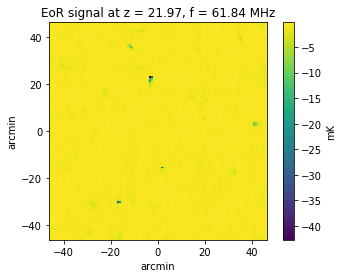

thickness= 33.32 Mpc, npx =   22 pix
******
Redshift = 22.43, Delta z = 0.470, f = 60.62313
./deltaTmap_z22.43_60.623MHz.fits
SDT of the 3D cube:  0.76867527 mK
STD of the  77 slice:  1.9868538 mK
Angular size of simulation is 1.5330 deg


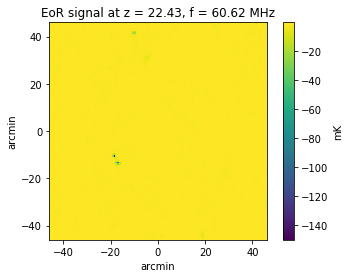

thickness= 33.05 Mpc, npx =   22 pix
******
Redshift = 22.90, Delta z = 0.480, f = 59.43096
./deltaTmap_z22.90_59.431MHz.fits
SDT of the 3D cube:  0.6955145 mK
STD of the  99 slice:  0.44167343 mK
Angular size of simulation is 1.5285 deg


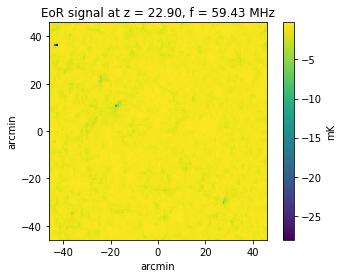

thickness= 32.76 Mpc, npx =   22 pix
******
Redshift = 23.38, Delta z = 0.480, f = 58.26087
./deltaTmap_z23.38_58.261MHz.fits
SDT of the 3D cube:  0.6439136 mK
STD of the  121 slice:  0.34429336 mK
Angular size of simulation is 1.5241 deg


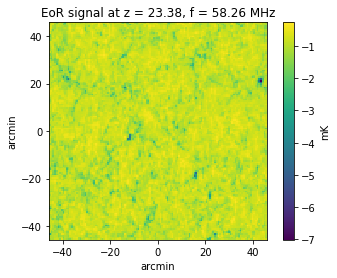

thickness= 31.80 Mpc, npx =   21 pix
******
Redshift = 23.86, Delta z = 0.500, f = 57.13596
./deltaTmap_z23.86_57.136MHz.fits
SDT of the 3D cube:  0.6004268 mK
STD of the  142 slice:  0.5615756 mK
Angular size of simulation is 1.5198 deg


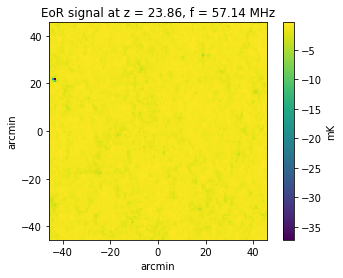

thickness= 32.16 Mpc, npx =   21 pix
******
Redshift = 24.36, Delta z = 0.510, f = 56.00946
./deltaTmap_z24.36_56.009MHz.fits
SDT of the 3D cube:  0.57249266 mK
STD of the  163 slice:  0.42828742 mK
Angular size of simulation is 1.5155 deg


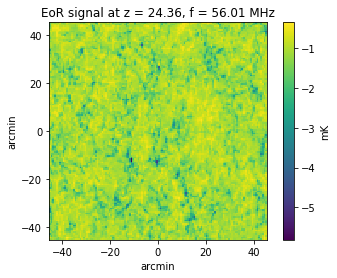

thickness= 31.84 Mpc, npx =   21 pix
******
Redshift = 24.87, Delta z = 0.510, f = 54.90530
./deltaTmap_z24.87_54.905MHz.fits
SDT of the 3D cube:  0.575792 mK
STD of the  184 slice:  0.4857055 mK
Angular size of simulation is 1.5113 deg


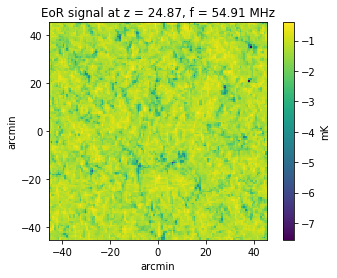

thickness= 30.92 Mpc, npx =   21 pix
beginning new cube !! 24.87
******
Redshift = 25.38, Delta z = 0.530, f = 53.84382
./deltaTmap_z25.38_53.844MHz.fits
SDT of the 3D cube:  0.5982518 mK
STD of the  10 slice:  0.5103952 mK
Angular size of simulation is 1.5072 deg


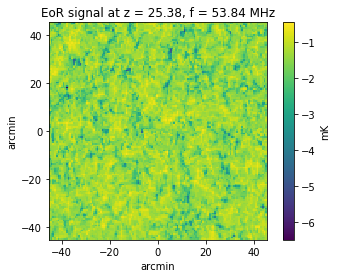

thickness= 31.19 Mpc, npx =   21 pix
******
Redshift = 25.91, Delta z = 0.540, f = 52.78335
./deltaTmap_z25.91_52.783MHz.fits
SDT of the 3D cube:  0.63462925 mK
STD of the  31 slice:  0.56566256 mK
Angular size of simulation is 1.5030 deg


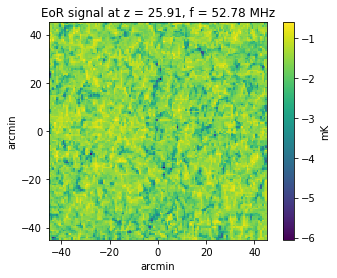

thickness= 30.85 Mpc, npx =   21 pix
******
Redshift = 26.45, Delta z = 0.550, f = 51.74499
./deltaTmap_z26.45_51.745MHz.fits
SDT of the 3D cube:  0.6835337 mK
STD of the  52 slice:  0.6913657 mK
Angular size of simulation is 1.4990 deg


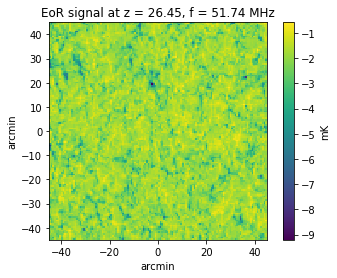

thickness= 30.50 Mpc, npx =   20 pix
******
Redshift = 27.00, Delta z = 0.560, f = 50.72857
./deltaTmap_z27.00_50.729MHz.fits
SDT of the 3D cube:  0.74434215 mK
STD of the  72 slice:  0.7359937 mK
Angular size of simulation is 1.4950 deg


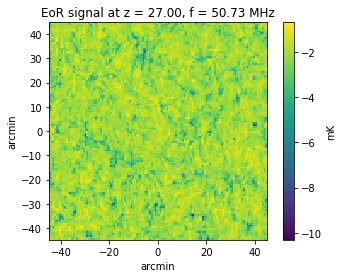

thickness= 30.14 Mpc, npx =   20 pix
******
Redshift = 27.56, Delta z = 0.570, f = 49.73389
./deltaTmap_z27.56_49.734MHz.fits
SDT of the 3D cube:  0.80426747 mK
STD of the  92 slice:  0.80289716 mK
Angular size of simulation is 1.4911 deg


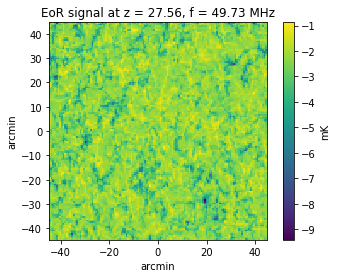

thickness= 29.78 Mpc, npx =   20 pix
******
Redshift = 28.13, Delta z = 0.580, f = 48.76073
./deltaTmap_z28.13_48.761MHz.fits
SDT of the 3D cube:  0.87621254 mK
STD of the  112 slice:  0.8147419 mK
Angular size of simulation is 1.4873 deg


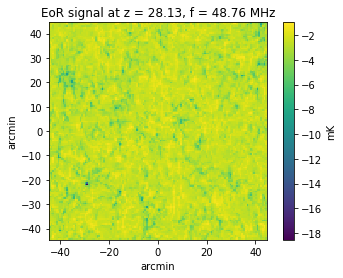

thickness= 29.42 Mpc, npx =   20 pix
******
Redshift = 28.71, Delta z = 0.600, f = 47.80882
./deltaTmap_z28.71_47.809MHz.fits
SDT of the 3D cube:  0.95291644 mK
STD of the  132 slice:  0.8906204 mK
Angular size of simulation is 1.4835 deg


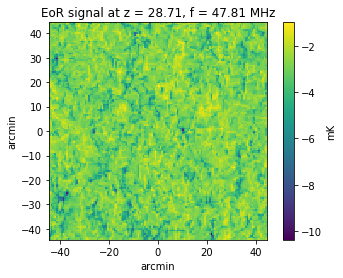

thickness= 29.54 Mpc, npx =   20 pix
******
Redshift = 29.31, Delta z = 0.600, f = 46.86242
./deltaTmap_z29.31_46.862MHz.fits
SDT of the 3D cube:  1.0373574 mK
STD of the  152 slice:  0.9953124 mK
Angular size of simulation is 1.4797 deg


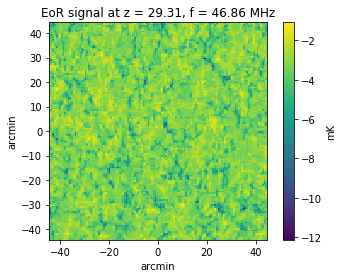

thickness= 28.68 Mpc, npx =   19 pix
******
Redshift = 29.91, f = 45.95277
./deltaTmap_z29.91_45.953MHz.fits
SDT of the 3D cube:  1.1240681 mK
STD of the  171 slice:  1.1103121 mK
Angular size of simulation is 1.4761 deg


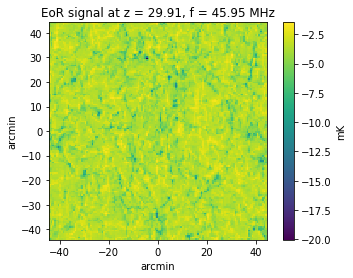

******


In [136]:
#The main loop
#Read datacubes in the comoving distance
for i in range(nz):
    z=redshifts[i]                      # define z
    freq=z2freq(z)                      # get a frequency
    if i < nz-1:                        # if not the last cube (with no delta_z defined)
        print("Redshift = %2.2f, Delta z = %1.3f, f = %3.5f"%(z,dz[i],freq))
    else:
        print("Redshift = %2.2f, f = %3.5f"%(z,freq))
    fileout = outdir + 'deltaTmap_z' + '%2.2f'%(z) + '_' + '%3.3f'%(freq) + 'MHz.fits'
    print(fileout)
#reading 21cmfast datacube into data(nbin,nbin,nbin) array
    with open(ffile_full[i],'rb') as f:
        data = np.fromfile(f, dtype=np.float32, count = nbin*nbin*nbin)
        data = np.reshape(data, (nbin, nbin, nbin) )
        print("SDT of the 3D cube: ", np.std(data), hdu.header['BUNIT'])
                
#get a slice of the datacube over y-axis, idx=slice_y
    map0 = data[:,slice_y,:]
    print("STD of the ", slice_y, "slice: ", np.std(map0), hdu.header['BUNIT'])
# get an angular size of the 21cmfast cube at the given z
    theta=ang_size(com_size,z)                   
    print('Angular size of simulation is %3.4f deg'%(theta))
     
# check if the simulation box is too small for a given FOV
    if (theta <= theta_fov):
        print('The simulation box is too small, exiting')
        print(theta,theta_fov)
        sys.exit()
# resize and rebin the map(nbin,nbin) of theta_x_theta (21cmfast cube size) to the map2(nbin_fov, nbin_fov)
# with required fov, theta_fov_x_theta_fov. It should be theta >= theta_fov - any of 21cmfast cube should have 
# an angular size more that required FOV.
    map2 = resize_and_rebin(map0,map2,theta,theta_fov)
    plt.imshow(map2, extent=[-theta*30, theta*30, -theta*30, theta*30])
    plt.xlabel('arcmin')
    plt.ylabel('arcmin')
    plt.colorbar(label="mK")
    plt.title("EoR signal at z = %.2f, f = %.2f MHz"%(z, freq))
    plt.show()
    
    if i < nz-1:                    # if not the last slice
        d1=com_dist(z)              # get comoving distance for a given z
        d2=com_dist(z+dz[i])        # get comoving distance for a z+delta_z
        deltay=d2-d1                # get the delta (delta_y in Mpc)
        npx=round(deltay/pixelsize)   # number of pixels I have to jump to obtain separation of 0.1 in redshift
        print ("thickness= %3.2f Mpc, npx = %4d pix"%(deltay, npx))

    if (np.sum(map2) != 0. ):               # if rebinned map2 is non-zero (?)
        slice_y=int(slice_y+npx)             # shift the slice in y-direction for the next z (next iteration)
        if (slice_y > nbin-slice_y_start):
            slice_y=slice_y_start               # when finished a cube start from beginning (a loop)
            print('beginning new cube !!',z)
    map3d[i] = map2.astype(np.float32)
    hdu.data = map2.astype(np.float32)
    hdu.writeto(fileout, overwrite=True)
    print("******") 

In [137]:
#Multifrequency 3D datacube output
#Create FITS header
# Set up an "Gnomonic" projection
# Vector properties may be set with Python lists, or Numpy arrays
# Frequency axis is incorrect (non-liear)!
w = wcs.WCS(naxis=3)
fstart = z2freq(redshifts[-1])
fend = z2freq(redshifts[0])
nx = nbin_fov
ny = nx
nfreq = nz
cdelt = theta_fov/nbin_fov
fdelt = (fend - fstart)/(nfreq - 1) 
w.wcs.crpix = [nx/2, ny/2, 1.0]
w.wcs.cdelt = np.array([-cdelt, cdelt, fdelt])
w.wcs.crval = [180., 0.0, fstart]
w.wcs.ctype = ["RA---TAN", "DEC--TAN", "FREQ"]
w.wcs.cunit = ["deg", "deg", "MHz"]
header = w.to_header()
hdu = fits.PrimaryHDU(header=header)
hdu.header['BUNIT'] = 'mK'
hdu.data = np.flip(map3d,0).astype(np.float32) # flip frequency axis to start from the lowest frequency
file3dcube = outdir + 'deltaT_3dcube_'+'%3.3f'%(fstart)+'-'+'%3.3f'%(fend)+'MHz.fits'
hdu.writeto(file3dcube, overwrite=True)